In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin, BaseEstimator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Masking
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df = pd.read_csv("/content/sample_data/labeled_data.csv")

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
tweets=df.tweet

In [ ]:
### Feature Generation

In [ ]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [ ]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [ ]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [ ]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [ ]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [ ]:
feats = get_feature_array(tweets)

In [ ]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [ ]:
M.shape

(24783, 4023)

In [ ]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [ ]:
### Model Setup

In [ ]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(18587, 4023)
(6196, 4023)
(6196,)
(18587,)


In [ ]:
X_train.fillna(method="pad", inplace=True)
X_test.fillna(method="pad", inplace=True)
y_train.fillna(method="pad", inplace=True)
y_test.fillna(method="pad", inplace=True)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))

In [ ]:
 def create_RNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, seq_len = 5):
    y_train, y_test = np.array(y_train_scaled)[seq_len-1:], np.array(y_test_scaled)[seq_len-1:]
    X_train = np.zeros((X_train_scaled.shape[0]+1-seq_len, seq_len, X_train_scaled.shape[1]))
    X_test = np.zeros((X_test_scaled.shape[0]+1-seq_len, seq_len, X_test_scaled.shape[1]))
    for i in range(seq_len):
        X_train[:, i, :] = np.array(X_train_scaled)[i:X_train_scaled.shape[0]+i+1-seq_len, :]
        X_test[:, i, :] = np.array(X_test_scaled)[i:X_test_scaled.shape[0]+i+1-seq_len, :]
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = create_RNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(18583, 5, 4023)
(6192, 5, 4023)
(6192, 1)
(18583, 1)


In [ ]:
simple_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[5, 4023])
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
simple_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 4025      
                                                                 
Total params: 4,025
Trainable params: 4,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple_RNN.compile(loss="mse", optimizer=optimizer)
history_simple_rnn = simple_RNN.fit(X_train, y_train, epochs=3,
                    validation_data=(X_test, y_test))

Epoch 1/3
581/581 [==============================] - 8s 10ms/step - loss: 0.0544 - val_loss: 0.0503
Epoch 2/3
581/581 [==============================] - 5s 9ms/step - loss: 0.0433 - val_loss: 0.0492
Epoch 3/3
581/581 [==============================] - 5s 9ms/step - loss: 0.0399 - val_loss: 0.0472


In [ ]:
scores = simple_RNN.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores*100))

Accuracy: 4.72%


In [ ]:
# Error Metrics
from sklearn.metrics import mean_squared_error
error_Training_simple_RNN = mean_squared_error(y_train, simple_RNN.predict(X_train))
simple_RNN_predicted = simple_RNN.predict(X_test)
error_Test_simple_RNN = mean_squared_error(y_test,simple_RNN_predicted)

In [ ]:
rmse = metrics.mean_squared_error(y_test,simple_RNN_predicted)
print ('Root Mean Squared Error:',rmse)
print('Accuracy rs : {}'.format(r2_score(y_test, simple_RNN_predicted)))

Root Mean Squared Error: 0.04724532065446159
Accuracy rs : 0.11334586699153204


Getting a negative R2 score here which means I have no error in my regression. An R2 of 0 would mean my regression is no better than taking the mean value, i.e. not using any information from the other variables. A Negative R2 means my model is doing worse than the mean value. Falk and Miller (1992) recommended that R2 values should be equal to or greater than 0.10 in order for the variance explained of a particular endogenous construct to be deemed adequate.

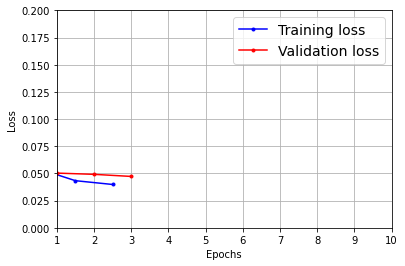

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 0.20])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_simple_rnn.history["loss"], history_simple_rnn.history["val_loss"])
plt.show()

In [ ]:
Deep_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[5,4023]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [ ]:
Deep_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 5, 20)             80880     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 20)             820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 81,722
Trainable params: 81,722
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Deep_RNN.compile(loss="mse", optimizer="adam")
history_Deep_RNN = Deep_RNN.fit(X_train, y_train, epochs=3,
                    validation_data=(X_test, y_test)) 

Epoch 1/50
581/581 [==============================] - 15s 22ms/step - loss: 0.0510 - val_loss: 0.0429
Epoch 2/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0341 - val_loss: 0.0440
Epoch 3/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0260 - val_loss: 0.0469
Epoch 4/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0193 - val_loss: 0.0526
Epoch 5/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0141 - val_loss: 0.0537
Epoch 6/50
581/581 [==============================] - 13s 22ms/step - loss: 0.0104 - val_loss: 0.0565
Epoch 7/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0079 - val_loss: 0.0579
Epoch 8/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0065 - val_loss: 0.0590
Epoch 9/50
581/581 [==============================] - 12s 21ms/step - loss: 0.0057 - val_loss: 0.0582
Epoch 10/50
581/581 [==============================] - 12s 21ms/step - loss: 0.004

In [ ]:
Deep_RNN.evaluate(X_test, y_test) 

194/194 [==============================] - 1s 5ms/step - loss: 0.0591


0.05909312143921852

In [ ]:
scores = Deep_RNN.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores*100))

Accuracy: 5.91%


In [ ]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Error Metrics
error_Training_Deep_RNN = mean_squared_error(y_train, Deep_RNN.predict(X_train))
Deep_RNN_predicted = Deep_RNN.predict(X_test)
error_Test_Deep_RNN = mean_squared_error(y_test,Deep_RNN_predicted)

In [ ]:
rmse = metrics.mean_squared_error(y_test,Deep_RNN_predicted)
print ('Root Mean Squared Error:',rmse)
print('Accuracy rs : {}'.format(r2_score(y_test, Deep_RNN_predicted)))

Root Mean Squared Error: 0.05909311795482275
Accuracy rs : -0.10900204594235463


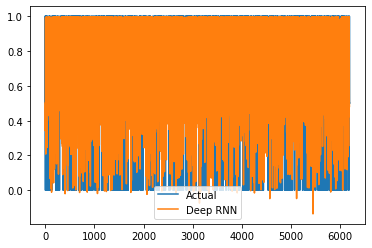

In [ ]:
plt.plot(y_test_scaled, label = "Actual")
plt.plot(Deep_RNN_predicted, label = "Deep RNN")
plt.legend()
plt.show()

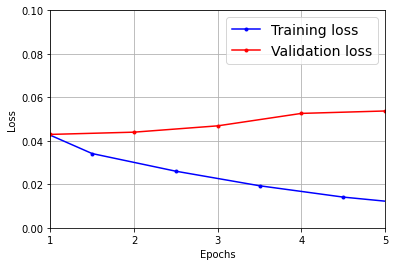

In [ ]:
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 5, 0, 0.10])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_Deep_RNN.history["loss"], history_Deep_RNN.history["val_loss"])
plt.show()

In [ ]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))

In [ ]:
def create_CNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, seq_len = 5):
    y_train_CNN, y_test_CNN = np.array(y_train_scaled)[seq_len-1:], np.array(y_test_scaled)[seq_len-1:]
    X_train_CNN = np.zeros((X_train_scaled.shape[0]+1-seq_len, seq_len, X_train_scaled.shape[1]))
    X_test_CNN = np.zeros((X_test_scaled.shape[0]+1-seq_len, seq_len, X_test_scaled.shape[1]))
    for i in range(seq_len):
        X_train_CNN[:, i, :] = np.array(X_train_scaled)[i:X_train_scaled.shape[0]+i+1-seq_len, :]
        X_test_CNN[:, i, :] = np.array(X_test_scaled)[i:X_test_scaled.shape[0]+i+1-seq_len, :]
    return X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN

In [ ]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = create_CNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

In [ ]:
# LSTM and CNN for sequence classification in the dataset
# create the model
embedding_vecor_length = 32
CNN = Sequential()
CNN.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(5,4023)))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(LSTM(100))
CNN.add(Dense(1, activation='sigmoid'))

In [ ]:
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(CNN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             386240    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 439,541
Trainable params: 439,541
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
CNN.fit(X_train_CNN, y_train_CNN, epochs=3, batch_size=128)

Epoch 1/50
146/146 [==============================] - 13s 8ms/step - loss: 0.6832 - accuracy: 0.1681
Epoch 2/50
146/146 [==============================] - 1s 8ms/step - loss: 0.6666 - accuracy: 0.1909
Epoch 3/50
146/146 [==============================] - 1s 8ms/step - loss: 0.6532 - accuracy: 0.2068
Epoch 4/50
146/146 [==============================] - 1s 9ms/step - loss: 0.6415 - accuracy: 0.2147
Epoch 5/50
146/146 [==============================] - 1s 8ms/step - loss: 0.6247 - accuracy: 0.2208
Epoch 6/50
146/146 [==============================] - 1s 8ms/step - loss: 0.6040 - accuracy: 0.2238
Epoch 7/50
146/146 [==============================] - 1s 8ms/step - loss: 0.5849 - accuracy: 0.2254
Epoch 8/50
146/146 [==============================] - 1s 8ms/step - loss: 0.5732 - accuracy: 0.2256
Epoch 9/50
146/146 [==============================] - 1s 8ms/step - loss: 0.5659 - accuracy: 0.2257
Epoch 10/50
146/146 [==============================] - 1s 8ms/step - loss: 0.5619 - accuracy: 0.225

In [ ]:
# Final evaluation of the model
scores = CNN.evaluate(X_test_CNN, y_test_CNN, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 14.95%
